# Simple Linear Models WITH HHS DATA

In [1]:
import matplotlib.pyplot as plt
import json
import os
import datetime
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import metrics
data_dir = './vaccine_data/hhs_data/'

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 999;

<IPython.core.display.Javascript object>

In [3]:
train_years = ['2013','2014']
dev_years = ['2015']
test_years = ['2016','2017']

train_download_dir = ('train',train_years)
dev_download_dir = ('dev',dev_years)
test_download_dir = ('test',test_years)
data_split_ls = [train_download_dir,dev_download_dir,test_download_dir]

In [4]:
def convert_to_calender_data(week_offset_from_aug_1,year):
    '''Returns the calender Week'''
    d = "{}-W{}".format(year,week_offset_from_aug_1+31)
    r = datetime.datetime.strptime(d + '-0', "%Y-W%W-%w")
    r = r.strftime("%B %d, %Y")    
    return r

In [5]:
convert_to_calender_data(15,2013)

'November 24, 2013'

## Plotting percentage trends year on year dev

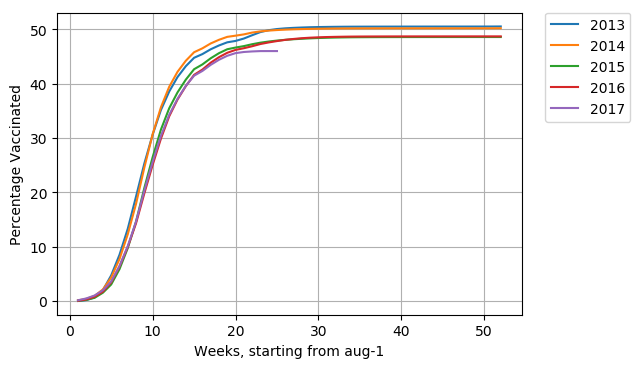

In [6]:
fig=plt.figure( dpi= 100)

for data_split in data_split_ls:
    split,years = data_split
    for year in years:
        data = pd.read_json(open(os.path.join(data_dir,split,year,'national.json')))
        data['percentage']=data['percentage']
        # data = data[['week','count','percentage','disparity','week_start']]
        plt.plot(data['week'],100*data['percentage'],label=year);
        
plt.grid()     
plt.xlabel('Weeks, starting from aug-1')
plt.ylabel('Percentage Vaccinated')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Plotting Year count trends year on year dev

Max Week => week_num 8, Date = October 06, 2013
Max Week => week_num 8, Date = October 05, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week_num 8, Date = October 02, 2016
Max Week => week_num 8, Date = October 01, 2017


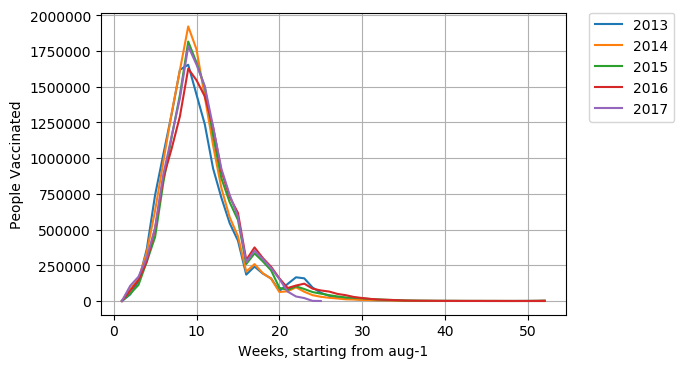

In [7]:
fig=plt.figure( dpi= 100)

for data_split in data_split_ls:
    split,years = data_split
    for year in years:
        data = pd.read_json(open(os.path.join(data_dir,split,year,'national.json')))
        data['percentage']=data['percentage']
        # data = data[['week','count','percentage','disparity','week_start']]
        count_vaccinated_week = (data['percentage']*data['count']).values
        count_vaccinated_week[1:]=count_vaccinated_week[1:]- count_vaccinated_week[0:-1]
        count_vaccinated_week[0]=0
        plt.plot(data['week'],count_vaccinated_week,label=year);
        print("Max Week => week_num {}, Date = {}".format(count_vaccinated_week.argmax(),convert_to_calender_data(count_vaccinated_week.argmax(),year)))
plt.grid()     
plt.xlabel('Weeks, starting from aug-1')
plt.ylabel('People Vaccinated')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# NY data

Max Week => week_num 7, Date = September 29, 2013
Max Week => week_num 8, Date = October 05, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week_num 8, Date = October 02, 2016
Max Week => week_num 8, Date = October 01, 2017


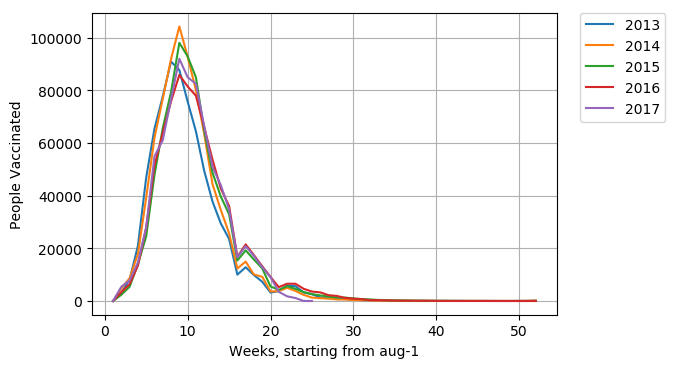

In [11]:
fig=plt.figure( dpi= 100)

for data_split in data_split_ls:
    split,years = data_split
    for year in years:
        data = pd.read_json(open(os.path.join(data_dir,split,year,'NY.json')))
        data['percentage']=data['percentage']
        # data = data[['week','count','percentage','disparity','week_start']]
        count_vaccinated_week = (data['percentage']*data['count']).values
        count_vaccinated_week[1:]=count_vaccinated_week[1:]- count_vaccinated_week[0:-1]
        count_vaccinated_week[0]=0
        plt.plot(data['week'],count_vaccinated_week,label=year);
        print("Max Week => week_num {}, Date = {}".format(count_vaccinated_week.argmax(),convert_to_calender_data(count_vaccinated_week.argmax(),year)))
plt.grid()     
plt.xlabel('Weeks, starting from aug-1')
plt.ylabel('People Vaccinated')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Plotting Google Trends

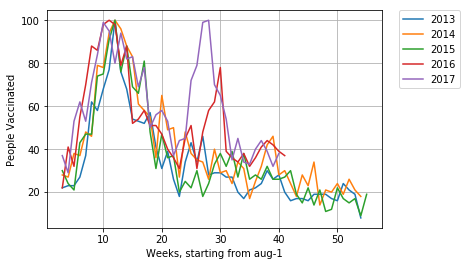

In [8]:
years = [2013,2014,2015,2016,2017]
for year in years:
    google_trends_df = pd.read_csv("vaccine_data/google_trends/google_national_trends_{}.csv".format(year),header=None)
    google_trends_df = google_trends_df[3:]
    google_trends_df = google_trends_df[[1]]
    google_trends_df = google_trends_df.astype('int')
    plt.plot((google_trends_df[1]),label=year)
    # plt.plot(list(google_trends_df[1].values),label=year);
plt.grid()     
plt.xlabel('Weeks, starting from aug-1')
plt.ylabel('People Vaccinated')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()



##  Predicting Percentage 
###  Predicting week n+f based on week n,n-1,n-2 ... n-p without padding


In [265]:
f_list = [i  for i in range(1,8)]
p_list = [i for i in range(1,15)]
error_year_dict = {}
model_year_dict = {}
for data_split in data_split_ls:
    split,years = data_split
    for year in years:
        error_mat = [[-1]*len(p_list) for i in range(len(f_list))]
        model_mat = [[-1]*len(p_list) for i in range(len(f_list))]

        for f in f_list:
            for p in p_list :           
                data = pd.read_json(open(os.path.join(data_dir,split,year,'national.json')))

                percent_vaccinated_week = (data['percentage']).values
                percent_vaccinated_week=percent_vaccinated_week[1:]- percent_vaccinated_week[0:-1]
                # count_vaccinated_week = [i for i in range(0,52)]
                Y = []
                X = []
                for i in range(p,len(percent_vaccinated_week)-f):
                    x_col = []
                    for j in range(i-p,i):
                        x_col.append(percent_vaccinated_week[j])
                    X.append(x_col)
                    Y.append(percent_vaccinated_week[i+f-1])
                # sanity checks
                assert(len(Y)==len(X))

                model = linear_model.LinearRegression()
                model.fit(X,Y)
                y_pred = model.predict(X)
                error = metrics.mean_squared_error(y_pred,Y)
                error_mat[f-1][p-1]=error*data['count'][0]
                model_mat[f-1][p-1]=(model.coef_,model.intercept_)
        error_year_dict[year] = error_mat
        model_year_dict[year] = model_mat

In [266]:
#"Error Matrix"
# columns is p (previous weeks taken into account)
# row is week-1 in future, 0 = 1 week into future
# error_year_dict.keys()
# error_year_dict
pd.DataFrame(error_year_dict['2013'])


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,598.343461,202.244047,187.750829,146.934734,145.511725,111.302336,54.186885,35.665010,30.903637,15.869231,15.408894,14.645393,13.681935,8.081575
1,2064.375862,750.943954,596.234612,460.208586,388.945409,207.418225,69.981623,42.038926,20.177729,18.480342,17.008049,15.665421,8.537263,5.775956
2,3928.380085,1597.315675,1218.622139,809.996242,531.868415,202.243089,63.836698,22.337528,19.120359,17.217643,15.904504,8.538586,5.800624,2.559958
3,5529.078559,2503.271272,1721.418403,875.378731,433.980852,142.028699,24.413757,19.120630,17.547771,17.569060,10.054928,6.321849,3.421066,2.365592
4,6483.881995,3319.515572,1878.062689,752.352199,359.394378,115.514871,44.741993,28.413947,25.441973,10.060090,6.525668,4.136144,2.823926,1.362074
5,6496.708737,3167.415177,1471.862586,559.708990,244.881552,95.548292,34.946876,26.290187,10.194098,6.530928,4.338801,3.229197,1.446237,1.086660
6,5389.239879,2509.514996,1140.580131,406.171963,206.072609,71.420941,31.633394,10.209993,6.892316,4.340435,3.311061,1.446237,1.110759,0.701926


### Train Predicting week n+f based on week n,n-1,n-2 ... n-p without padding

In [291]:
f_list = [i  for i in range(1,8)]
p_list = [i for i in range(1,15)]
error_year_dict = {}
model_year_dict = {}
for data_split in data_split_ls:
    split,years = data_split
    for year in years:
        error_mat = [[-1]*len(p_list) for i in range(len(f_list))]
        model_mat = [[-1]*len(p_list) for i in range(len(f_list))]

        for f in f_list:
            for p in p_list :           
                data = pd.read_json(open(os.path.join(data_dir,split,year,'national.json')))
                count_vaccinated_week = (data['percentage']*data['count']).values
                count_vaccinated_week=count_vaccinated_week[1:]- count_vaccinated_week[0:-1]
                # count_vaccinated_week = [i for i in range(0,52)]
                Y = []
                X = []
                for i in range(p,len(count_vaccinated_week)-f):
                    x_col = []
                    for j in range(i-p,i):
                        x_col.append(count_vaccinated_week[j])
                    X.append(x_col)
                    Y.append(count_vaccinated_week[i+f-1])
                # sanity checks
                assert(len(Y)==len(X))

                model = linear_model.LinearRegression()
                model.fit(X,Y)
                y_pred = model.predict(X)
                error = metrics.mean_squared_error(y_pred,Y)
                error_mat[f-1][p-1]=error
                model_mat[f-1][p-1]=(model.coef_,model.intercept_)
               
        error_year_dict[year] = error_mat
        model_year_dict[year] = model_mat

In [292]:
#"Error Matrix"
# columns is p (previous weeks taken into account)
# row is week-1 in future, 0 = 1 week into future
# error_year_dict.keys()
# error_year_dict

pd.DataFrame(error_year_dict['2013'])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.632213e+10,5.516988e+09,5.121630e+09,4.008213e+09,3.969395e+09,3.036201e+09,1.478157e+09,9.729010e+08,8.430161e+08,4.328946e+08,4.203371e+08,3.995097e+08,3.732277e+08,2.204562e+08
1,5.631383e+10,2.048490e+10,1.626460e+10,1.255397e+10,1.060999e+10,5.658134e+09,1.909019e+09,1.146774e+09,5.504255e+08,5.041228e+08,4.639603e+08,4.273349e+08,2.328868e+08,1.575615e+08
2,1.071618e+11,4.357296e+10,3.324263e+10,2.209578e+10,1.450877e+10,5.516962e+09,1.741393e+09,6.093424e+08,5.215817e+08,4.696778e+08,4.338568e+08,2.329229e+08,1.582344e+08,6.983274e+07
3,1.508270e+11,6.828640e+10,4.695834e+10,2.387934e+10,1.183851e+10,3.874382e+09,6.659796e+08,5.215891e+08,4.786833e+08,4.792640e+08,2.742870e+08,1.724529e+08,9.332280e+07,6.453065e+07
4,1.768729e+11,9.055262e+10,5.123142e+10,2.052331e+10,9.803871e+09,3.151115e+09,1.220511e+09,7.751002e+08,6.940282e+08,2.744278e+08,1.780128e+08,1.128293e+08,7.703348e+07,3.715582e+07
5,1.772228e+11,8.640349e+10,4.015074e+10,1.526823e+10,6.680091e+09,2.606449e+09,9.533111e+08,7.171665e+08,2.780834e+08,1.781563e+08,1.183576e+08,8.808883e+07,3.945169e+07,2.964286e+07
6,1.470123e+11,6.845672e+10,3.111373e+10,1.107991e+10,5.621427e+09,1.948282e+09,8.629231e+08,2.785170e+08,1.880146e+08,1.184021e+08,9.032198e+07,3.945170e+07,3.030025e+07,1.914774e+07


# Predicting Std Dev of each week with normalized data

In [274]:
split = 'train'
train_years = ['2013','2014']
X = []
for year in train_years:
    data_df = pd.read_json(open(os.path.join(data_dir,split,year,'national.json')))
    X.append(data_df['percentage'].values)
X = np.asarray(X)
week_means = X.mean(axis = 0)

In [294]:
data_split_ls = [train_download_dir,dev_download_dir]
f_list = [i  for i in range(1,8)]
p_list = [i for i in range(1,15)]
error_year_dict = {}
model_year_dict = {}
for data_split in data_split_ls:
    split,years = data_split
    for year in years:
        error_mat = [[-1]*len(p_list) for i in range(len(f_list))]
        model_mat = [[-1]*len(p_list) for i in range(len(f_list))]

        for f in f_list:
            for p in p_list :           
                data = pd.read_json(open(os.path.join(data_dir,split,year,'national.json')))

                percent_vaccinated_week = (data['percentage']).values
                percent_vaccinated_week = percent_vaccinated_week -  week_means
                # percent_vaccinated_week=percent_vaccinated_week[1:]- percent_vaccinated_week[0:-1]

                
                # count_vaccinated_week = [i for i in range(0,52)]
                Y = []
                X = []
                for i in range(p,len(percent_vaccinated_week)-f):
                    x_col = []
                    for j in range(i-p,i):
                        x_col.append(percent_vaccinated_week[j])
                    X.append(x_col)
                    Y.append(percent_vaccinated_week[i+f-1])
                # sanity checks
                assert(len(Y)==len(X))

                model = linear_model.LinearRegression()
                model.fit(X,Y)
                y_pred = model.predict(X)
                error = metrics.mean_squared_error(y_pred,Y) * data['count'][0]
                error_mat[f-1][p-1]=error
                model_mat[f-1][p-1]=(model.coef_,model.intercept_)
        error_year_dict[year] = error_mat
        model_year_dict[year] = model_mat

In [1]:
#"Error Matrix"
# columns is p (previous weeks taken into account)
# row is week-1 in future, 0 = 1 week into future
# error_year_dict.keys()
# error_year_dict

# Error in dev of percentage * number of people enrolled in medicare+medicalim in that year
pd.DataFrame(error_year_dict['2013'])

NameError: name 'pd' is not defined

# Dev error

In [296]:
#"Error Matrix"
# columns is p (previous weeks taken into account)
# row is week-1 in future, 0 = 1 week into future
# error_year_dict.keys()
# error_year_dict

pd.DataFrame(error_year_dict['2015'])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,195.856316,41.312253,39.588747,40.254973,19.529680,17.295191,16.289864,5.476197,5.386638,2.572445,1.774150,0.833845,0.645648,0.462930
1,635.595234,142.166213,136.407698,123.767477,71.328704,62.498642,37.546096,16.066061,14.911274,6.940328,5.836247,2.228922,2.162065,1.834104
2,1090.638416,285.564412,289.898726,253.920603,144.686681,100.326557,56.889873,23.207274,18.514670,8.590428,5.956924,3.289204,3.138461,2.145693
3,1369.308695,505.138635,501.625667,421.303557,179.645270,111.830334,54.006451,24.894113,18.113318,6.787039,5.089769,3.519363,2.384159,1.011716
4,1458.003329,671.444031,637.007019,434.488155,170.101121,96.250613,48.564380,21.150853,11.861643,5.527098,4.769497,2.390581,1.064673,0.220203
5,1382.229153,764.090785,628.507020,403.656675,133.526675,80.757898,38.369287,12.285226,6.479656,4.789076,3.207902,1.089533,0.466968,0.297453
6,1211.102683,710.169818,542.154191,309.061448,103.413414,59.136996,21.935045,6.530111,4.908627,3.233125,1.443077,0.495649,0.429538,0.339758
